<a href="https://colab.research.google.com/github/OfekYa/Deep-Learning/blob/main/Training_Deep_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set DataLoader to a tabular data collection, and use it to train several Deep Neural Networks and predict CLASS

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch import nn

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/diabetes.csv'

QUANTILES = 10
FRAC = 0.8
BATCH_SIZE = 10
NUM_OF_EPOCHS = 10
table_columns = ['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Y', 'Class']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Sections C, D, E**

**C:** Calculate the decimals of the 'Y' variable in the dataset.

  We will refer to the labels according to the correction in the forum, so that 1 is the tenth of the lowest values, and 10 is the tenth of the highest.

**D:** Add a new variable called 'Class' whose values are the decile to which each sample belongs.

**E:** Create a PyTorch Dataset object that wraps this dataset.

In [ ]:

class DiabetesDataset(Dataset):

    def __init__(self, data_file, img_cols, target_col):
        if not isinstance(data_file, pd.DataFrame):
            df = pd.read_csv(data_file, sep='\t')

            df['Class'] = pd.qcut(df['Y'], q=QUANTILES, labels=np.arange(QUANTILES)+1) # labels: [1, 2, 3,...,QUANTILES+1]  # Sections C and D
            #df['Class_div'] = pd.qcut(df['Y'], q=QUANTILES) #  the distribution ranges that the Y values ​​are in.

        else:  # data_file is instance of DataFrame because we split the data for training and testing.
            df = data_file

        self.df = df
        self.img_cols = img_cols
        self.target_col = target_col
        # print(df.head(50))

    def __getitem__(self, idx):
        img = self.df[self.img_cols].iloc[idx]
        img = torch.tensor(img.values, dtype=torch.float32)
        label = self.df[self.target_col].iloc[idx]
        label = torch.tensor(label, dtype=torch.long)
        return img, label

    def __len__(self):
        return self.df.shape[0]



# **Sections F, G:**
**F:** Create a DataLoader object that loads the data in Minibatches (batch.size = 10).

**G:** Print a single Batch from the dataset.

In [ ]:

def print_single_batch(features, target):
    data_table = DiabetesDataset(file_path, features, target)  
    train_dataloader = DataLoader(data_table, batch_size=BATCH_SIZE, shuffle=True)  # Section F
    imgs, labels = next(iter(train_dataloader))
    print(imgs, '\n', labels)  

print_single_batch(table_columns[:-1], table_columns[-1])   # Section G


tensor([[ 58.0000,   1.0000,  28.1000, 111.0000, 198.0000,  80.6000,  31.0000,
           6.0000,   6.0684,  93.0000, 273.0000],
        [ 41.0000,   1.0000,  20.2000,  62.0000, 153.0000,  89.0000,  50.0000,
           3.0000,   4.2485,  89.0000,  77.0000],
        [ 39.0000,   2.0000,  26.9000,  93.0000, 136.0000,  75.4000,  48.0000,
           3.0000,   4.1431,  99.0000,  67.0000],
        [ 62.0000,   2.0000,  33.3000, 114.0000, 182.0000, 114.0000,  38.0000,
           5.0000,   5.0106,  96.0000, 275.0000],
        [ 27.0000,   2.0000,  33.6000, 110.0000, 246.0000, 156.6000,  57.0000,
           4.0000,   5.0876,  89.0000, 233.0000],
        [ 60.0000,   1.0000,  22.2000, 104.6700, 221.0000, 105.4000,  60.0000,
           3.6800,   5.6276,  93.0000,  90.0000],
        [ 48.0000,   1.0000,  19.9000,  91.0000, 189.0000, 109.6000,  69.0000,
           3.0000,   3.9512, 101.0000,  48.0000],
        [ 57.0000,   2.0000,  31.6000, 117.0000, 225.0000, 107.6000,  40.0000,
           6.0000,

# **Section J:**
**J:** Splitting the data into training data and test data.

In [ ]:
def split_data(data_file, features, target):

    df = pd.read_csv(data_file, sep='\t')
    df['Class'] = pd.qcut(df['Y'], q=QUANTILES, labels=np.arange(QUANTILES) + 1)
    training_df = df.sample(frac=FRAC)
    test_df = df.drop(training_df.index)
    train_data = DiabetesDataset(training_df, features, target)
    test_data = DiabetesDataset(test_df, features, target)

    return train_data, test_data

# **Sections H, I, J, K:**
**H:** Use DataLoader to train a deep neural network that predicts 'Class' based on the other variables.

**I:** Use DataLoader to train a deep neural network that predicts 'Class' based on the other variables except  'Y'.

**J:** Test the performance of the networks on a random test set containing 20% ​​of the dataset.

**K:** Explain the difference in network performance.

**K answer:** When we train the network on the data including 'Y' then we will get a much higher accuracy because the 'Y' variable has the greatest weight to influence the 'Class' value.

In [ ]:


def train_network(features, target, split=False, several_epochs=True):

    if split is True:
        train_data, test_data = split_data(file_path, features, target)
        test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

    else:
        train_data = DiabetesDataset(file_path, features, target)  # Section E

    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)  # Section F
    num_of_features = len(features)

    model = nn.Sequential(
        nn.Linear(num_of_features, 110),
        nn.ReLU(),
        nn.Linear(110, 110),
        nn.ReLU(),
        nn.Linear(110, QUANTILES+1),
        nn.LogSoftmax(dim=1)
    )  # return a Probabilities Vector
    #print(model)

    def reset_model_params():
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    # Running NLLLoss() immediately after LogSoftmax yields the cross entropy, which we want to use.
    CE_loss = nn.NLLLoss()  # Cross Entorpy = Negative Log Likelihood Loss .
    reset_model_params()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # lr is the learning rate used for both models' optimizers

    def iterate_batch(imgs, labels):  # Iteration of the training loop
        # imgs = imgs.flatten(start_dim=1)   # imgs already is a one-dimensional tensor
        optimizer.zero_grad()  # Reset the gradient of the parameters
        y_model = model(imgs)  # Entering the data into the network and calculating predicted probabilities
        loss = CE_loss(y_model, labels)  # Calculate the loss function on current minibatch.
        loss.backward()  # Calculation of the random gradient
        optimizer.step()  # update values of (Weights, bias)

        """ Let's convert the vector of probabilities into an unequivocal classification:
            We will use argmax(vector_probabilities) and assume that the model classifies each given sample to
            the class with the highest probability in its output """
        predicted_labels = y_model.argmax(dim=1)
        acc = (predicted_labels == labels).sum() / len(labels)  # acc = the proportion of samples that the model classifies correctly.
        return loss.detach(), acc.detach()

    def iterate_epoch():
        num_of_train_batches = len(train_dataloader)  # total number of batches = math.ceil(len(data_table)/BATCH_SIZE)
        running_loss = 0.
        running_acc = 0.
        for imgs, labels in train_dataloader:
            batch_loss, batch_acc = iterate_batch(imgs, labels)
            running_loss += batch_loss
            running_acc += batch_acc
        loss = running_loss / num_of_train_batches
        acc = running_acc / num_of_train_batches
        return loss, acc

    def eval_model_test():
        loss = 0.
        acc = 0.
        num_of_test_batches = len(test_dataloader)
        for imgs, labels in test_dataloader:
            imgs = imgs.flatten(start_dim=1)
            with torch.no_grad():
                y_model = model(imgs)
                loss += CE_loss(y_model, labels)
                predicted_labels = y_model.argmax(dim=1)
                acc += (predicted_labels == labels).sum() / len(labels)
        return loss / num_of_test_batches, acc / num_of_test_batches

    def train_by_several_epochs():
        loss_train = torch.zeros(NUM_OF_EPOCHS)  # Tensor of 0's in size = num_of_epochs
        acc_train = torch.zeros(NUM_OF_EPOCHS)  # Tensor of 0's in size = num_of_epochs
        if split is True:
            loss_test = torch.zeros(NUM_OF_EPOCHS)
            acc_test = torch.zeros(NUM_OF_EPOCHS)

        model[0].reset_parameters()
        for epoch_idx in tqdm(range(NUM_OF_EPOCHS)):
            loss_train[epoch_idx], acc_train[epoch_idx] = iterate_epoch()
            if split is True:
                loss_test[epoch_idx], acc_test[epoch_idx] = eval_model_test()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, NUM_OF_EPOCHS + 1), loss_train);
        plt.title("CE loss");
        plt.xlabel("Epoch Number");
        plt.subplot(1, 2, 2)
        plt.plot(range(1, NUM_OF_EPOCHS + 1), acc_train);
        plt.title("Accuracy");
        plt.xlabel("Epoch Number");
        plt.show()

        if split is True:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(range(1, NUM_OF_EPOCHS + 1), loss_train, label="train loss");
            plt.plot(range(1, NUM_OF_EPOCHS + 1), loss_test, label="test loss");
            plt.title("CE loss");
            plt.legend()
            plt.xlabel("Epoch Number");
            plt.subplot(1, 2, 2)
            plt.plot(range(1, NUM_OF_EPOCHS + 1), acc_train, label="train acc");
            plt.plot(range(1, NUM_OF_EPOCHS + 1), acc_test, label="test acc");
            plt.title("Accuracy");
            plt.legend()
            plt.xlabel("Epoch Number");
            plt.show()

    
    def train_by_single_epoch():
        num_of_batches = len(train_dataloader)
        loss = torch.zeros(num_of_batches)  # Tensor of 0's in size = num_of_batches
        acc = torch.zeros(num_of_batches)   # Tensor of 0's in size = num_of_batches
        for idx, (imgs, labels) in enumerate(train_dataloader):
            loss[idx], acc[idx] = iterate_batch(imgs, labels)

        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(range(num_of_batches), loss);
        plt.title("CE loss");
        plt.xlabel("Batch Number");
        plt.subplot(1,2,2)
        plt.plot(range(num_of_batches), acc);
        plt.title("Accuracy");
        plt.xlabel("Batch Number");
        plt.show()

    if several_epochs is True:
        train_by_several_epochs()
    else:
        train_by_single_epoch()

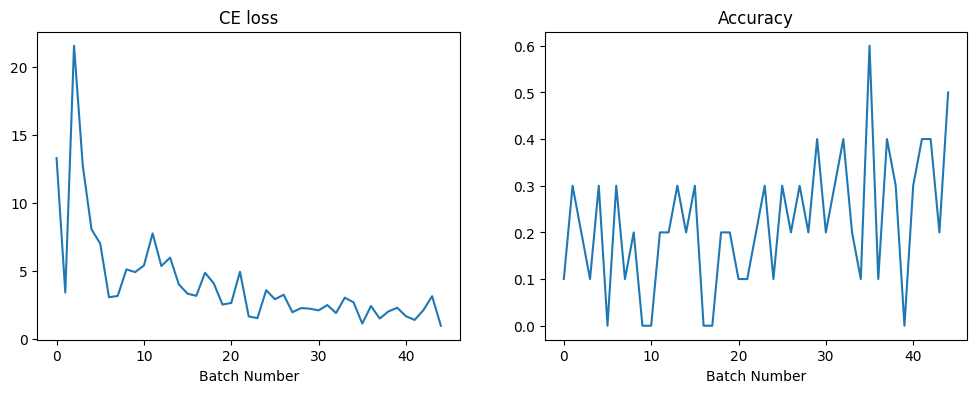

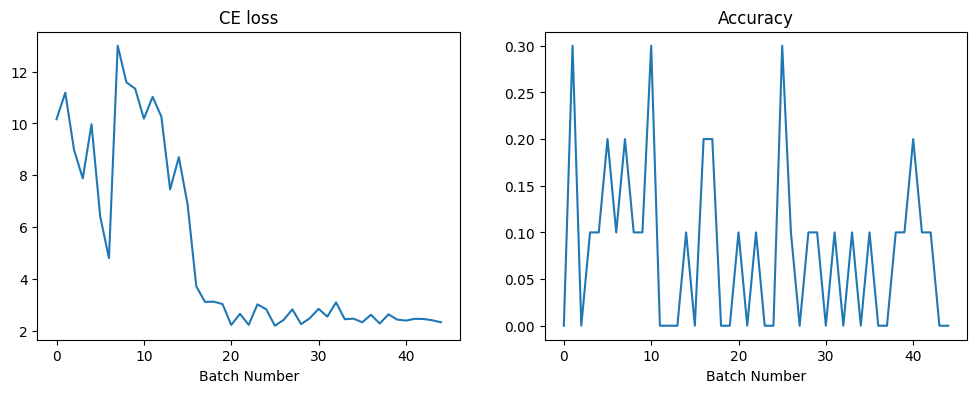

In [ ]:

train_network(table_columns[:-1], table_columns[-1], several_epochs=False)  # Section H: Network training according to all features, single epoch
train_network(table_columns[:-2], table_columns[-1], several_epochs=False)  # Section H: Network training according to all features, single epoch

100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


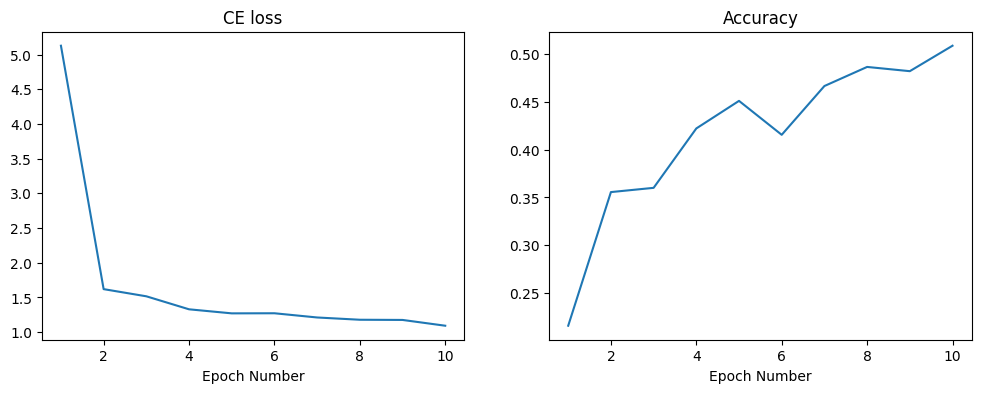

In [ ]:
train_network(table_columns[:-1], table_columns[-1])  # Section H: Network training according to all features, several epochs.


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


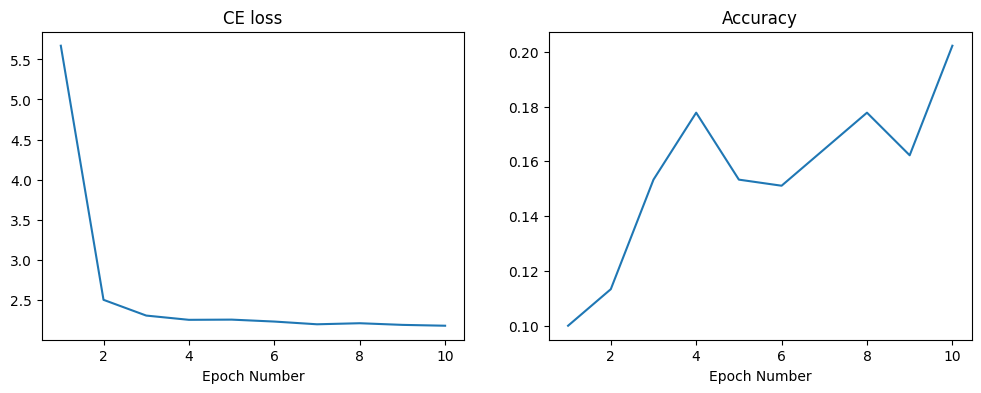

In [ ]:
train_network(table_columns[:-2], table_columns[-1])  # Section I: Network training according to all features except 'Y', several epochs.


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


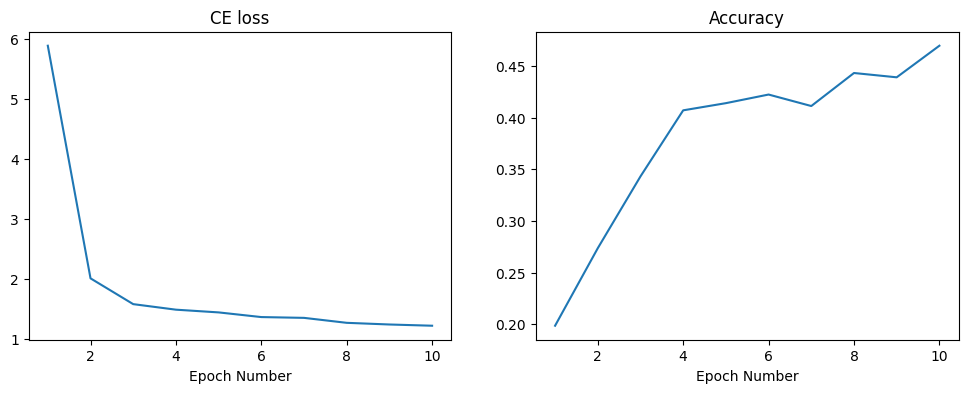

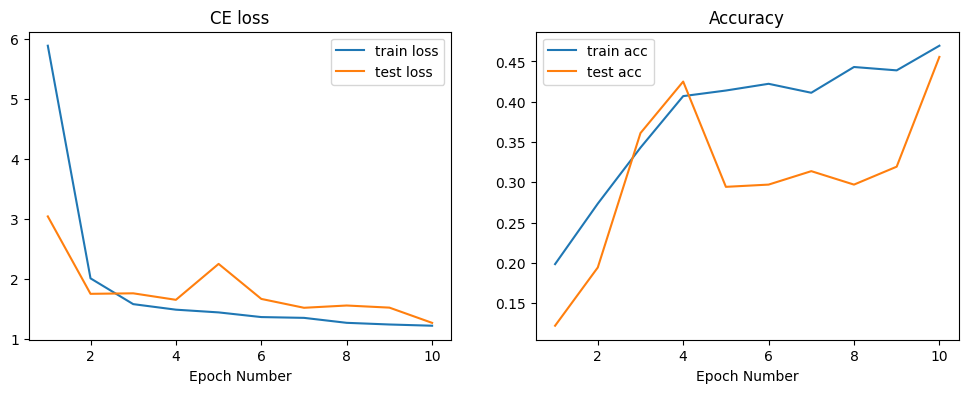

In [ ]:
train_network(table_columns[:-1], table_columns[-1], split=True)  # Section J1 : Train and Test Network training according to all features, several epochs.


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


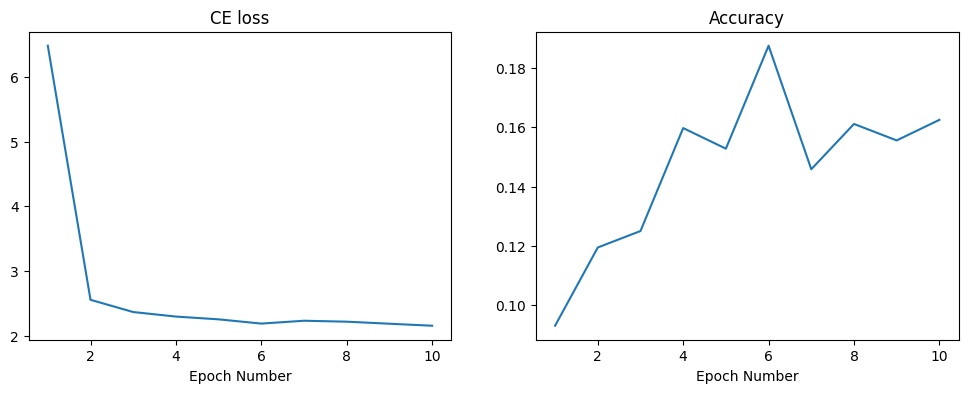

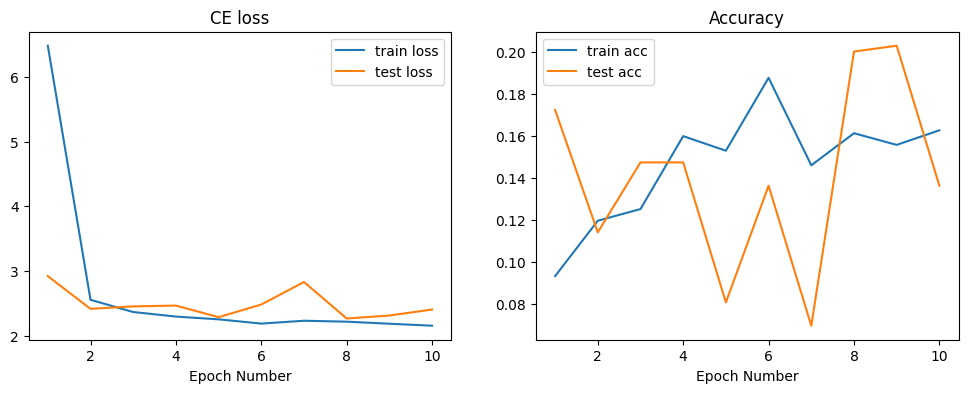

In [ ]:
train_network(table_columns[:-2], table_columns[-1], split=True)  # Section J2 : Train and Test Network training according to all features except 'Y', several epochs.

# **Sections L, M, N:**
**L:** Divide the variable 'Y' into percentiles instead of deciles and calculate the new 'Class' values accordingly.

**M:** Repeat sections H, I, J with the updated 'Class' variable.

**N:** Would you prefer to use percentiles or decimals?

**N answer:** In this case we would prefer to use a deciles because that way the probability of accuracy will be higher because the chance is divided by 10 and not by 100.                                
But in general, in my opinion it depends on what the purpose of the division into different labels is.


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


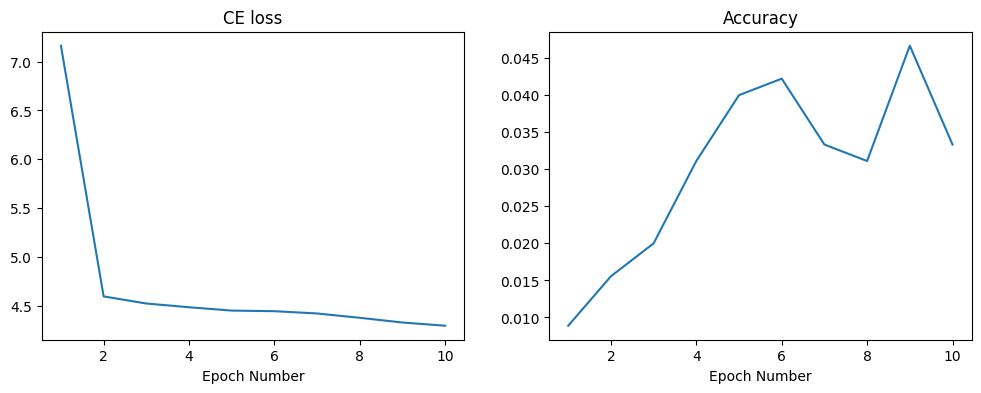

In [ ]:

QUANTILES = 100
train_network(table_columns[:-1], table_columns[-1])  # Section H: Network training according to all features, several epochs.



100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


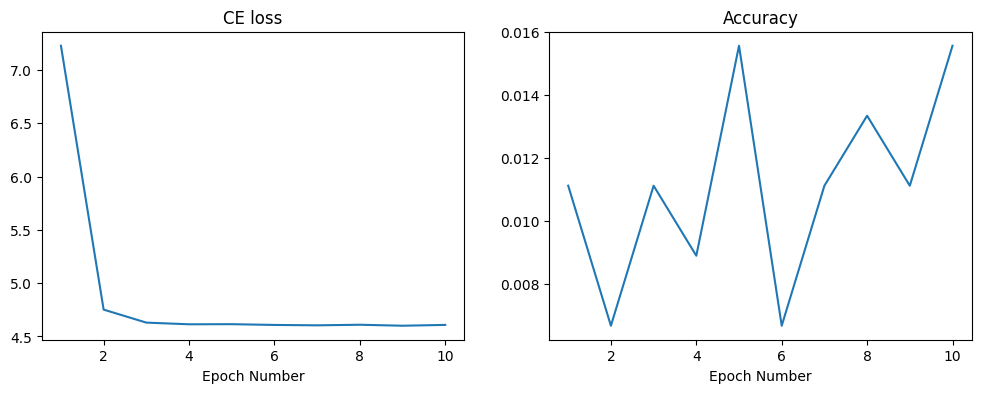

In [ ]:

train_network(table_columns[:-2], table_columns[-1])  # Section I: Network training according to all features except 'Y', several epochs.



100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


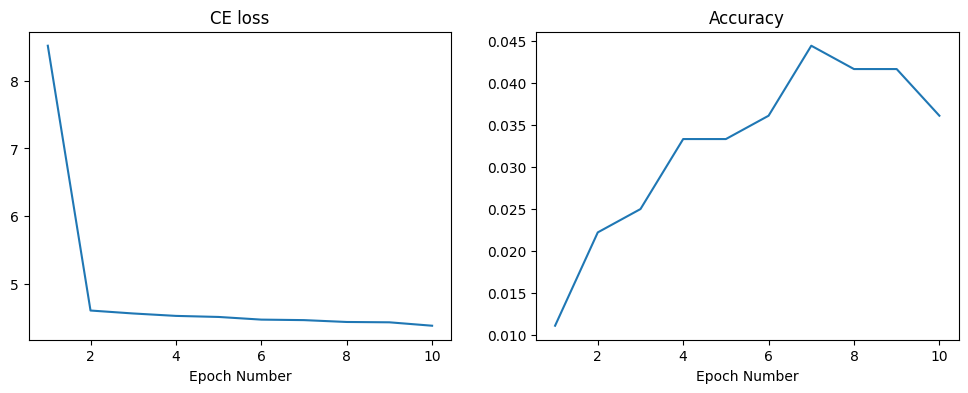

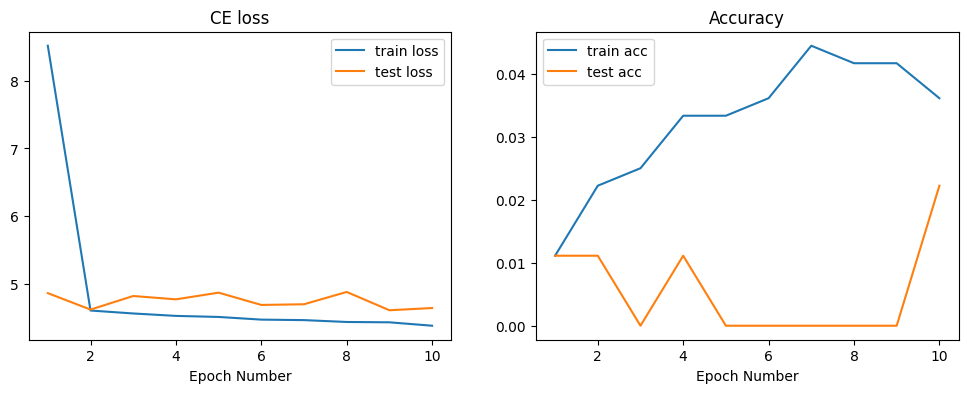

In [ ]:
train_network(table_columns[:-1], table_columns[-1], split=True)  # Section J1 : Train and Test Network training according to all features, several epochs.


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


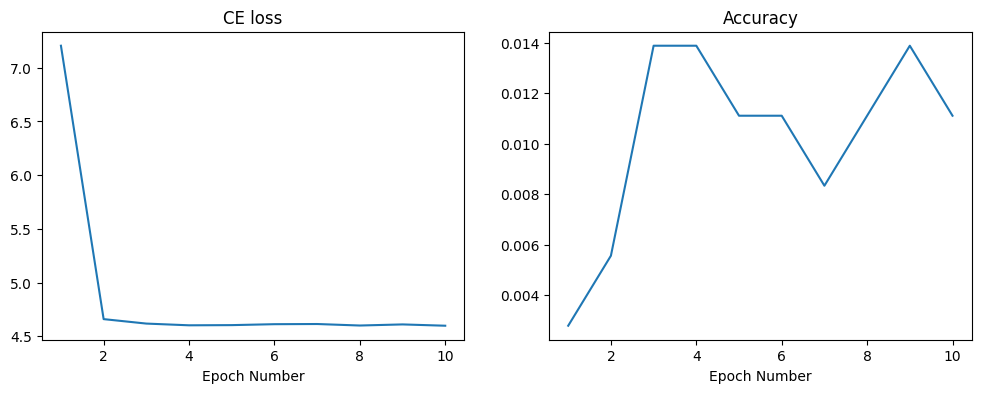

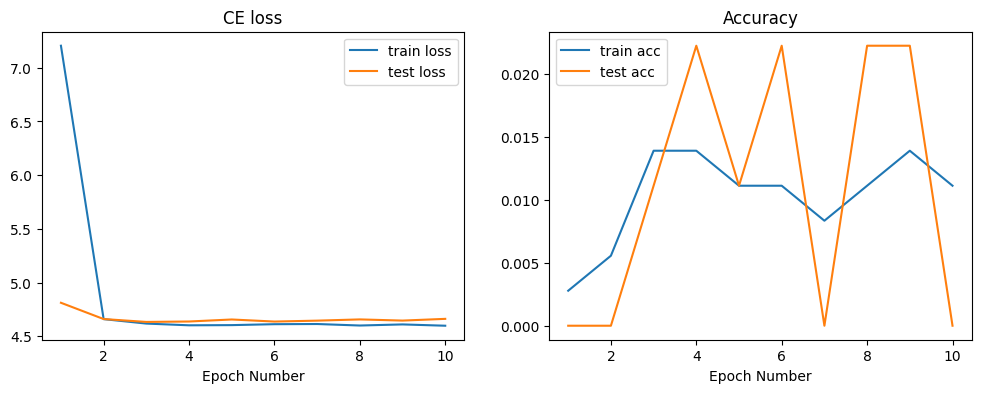

In [ ]:
train_network(table_columns[:-2], table_columns[-1], split=True)  # Section J2 : Train and Test Network training according to all features except 'Y', several epochs.